<a href="https://colab.research.google.com/github/Dyakonov/Colab/blob/main/dj_DistanceLearning_small_abs_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Обучение модулю

Сделал, чтобы разобраться с эффектом на совсем простой задаче

Делаю для удобства экспериментов...


ТАМ ЗАВИСИМОСТЬ РЕЖИМА: TRAIN или EVAL! - но странно, почему тут это выстреливает!

In [1]:
import torch
from torch import nn, optim
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

from IPython import display
import numpy as np
from matplotlib import pyplot as plt
import copy
from torch.optim.lr_scheduler import StepLR

# инициализация генератора псевдослучайных чисел

def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available(): # для GPU отдельный seed
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

set_seed(43)

# есть стохастические операции на GPU
# сделаем их детерминированными для воспроизводимости
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

In [2]:
def makeXtrain(m, device):
  # делаем выборку
  X = torch.rand(m, 1) - 0.5
  y = X.abs()
  return X.to(device), y.to(device);

In [4]:
def model_L_DN_F(width, nlayers):
  """
  сеть Linear + BN + ReLU
  """
  model = torch.nn.Sequential()
  model.add_module('L0', nn.Linear(1, width, bias=False)) # c bias=False - НЕ УЧИТСЯ!!!
  model.add_module('BN0',  nn.BatchNorm1d(width))
  for i in range(nlayers - 2):
    model.add_module('RELU' + str(i),  nn.ReLU())
    model.add_module('L'+str(i+1),  nn.Linear(width, width, bias=False)) # , bias=False
    model.add_module('BN'+str(i+1),  nn.BatchNorm1d(width))
  model.add_module('RELU' + str(nlayers - 2),  nn.ReLU())
  model.add_module('L' + str(nlayers - 1),  nn.Linear(width, 1))
  return(model)

In [5]:
def train_model(model, optimizer, scheduler, n_epoches = 1000, m = 10000, device=device, use_scheduler=True):
  losses1 = np.zeros(n_epoches)
  losses2 = np.zeros(n_epoches)

  # контроль
  X_test, y_test = makeXtrain(m=m, device=device)
  # X_train, y_train = makeXtrain(m=m, n0=n0, device=device) # ПЕРЕНЁС СЮДА - ВЕРНУТЬ!!!!!!

  X_train, y_train = makeXtrain(m=m, device=device)

  for t in range(n_epoches):
    # обучение
    # небольшой датасет - сразу по всему!
    # X_train, y_train = makeXtrain(m=m, device=device)

    model.train()
    a_train = model(X_train)
    loss = criterion(a_train, y_train)
    optimizer.zero_grad(set_to_none=True) # обнулить градиент ###
    loss.backward()  # обратный проход
    optimizer.step() # поправка весов

    if use_scheduler:
      scheduler.step() # поправка LR

    model.eval() ####
    with torch.no_grad():
        a_test = model(X_test)
        test_loss = criterion(a_test, y_test)

    losses1[t] = loss.item() / (criterion(y_train, y_train*0 + y_train.mean()).item()) # НОРМИРОВКА
    losses2[t] = test_loss.item() / (criterion(y_test, y_test*0 + y_test.mean()).item()) # НОРМИРОВКА
    #print("[EPOCH]: %i, [LOSS]: %.6f, [LOSS2]: %.6f" % (t, losses1[t], losses2[t]))

  return losses1, losses2

In [13]:
m = 10000 # число объектов в выборке
depth = 3 # увеличение признакового пространства в сети
nlayers = 5 # число слоёв в сети
# learning_rate = 0.1 # 1e-3 - не обучится!
use_scheduler = True
n_epoches = 1000

LRs = np.logspace(-3, 0, 21) # увеличил - 21! [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0]
n_exp = len(LRs)
L1 = np.zeros((n_exp, n_epoches))
L2 = np.zeros((n_exp, n_epoches))
for t, learning_rate in enumerate(LRs):
  set_seed(t)
  model = model_L_DN_F(1*depth, nlayers)
  model.to(device)
  # MSE
  criterion = nn.MSELoss()
  # оптимизатор
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  # программатор
  scheduler = StepLR(optimizer, step_size=10, gamma=0.95) # 0.9 - очень сильно
  L1[t,:], L2[t,:] = train_model(model, optimizer, scheduler, n_epoches = n_epoches, m = m, device=device, use_scheduler=use_scheduler)
  print("[EXP]: %i, [LR]: %.6f, [LOSS1]: %.6f, [LOSS2]: %.6f" % (t, learning_rate, L1[t,-1], L2[t,-1]))
  display.clear_output(wait=True)

[EXP]: 20, [LR]: 1.000000, [LOSS1]: 1.000000, [LOSS2]: 1.000236


In [14]:
optimizer.param_groups[0]['lr']

0.005920529220333997

<ipython-input-18-16f62b26d656>:8: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim([0, 10])


(1.0033076118591177e-05, 10)

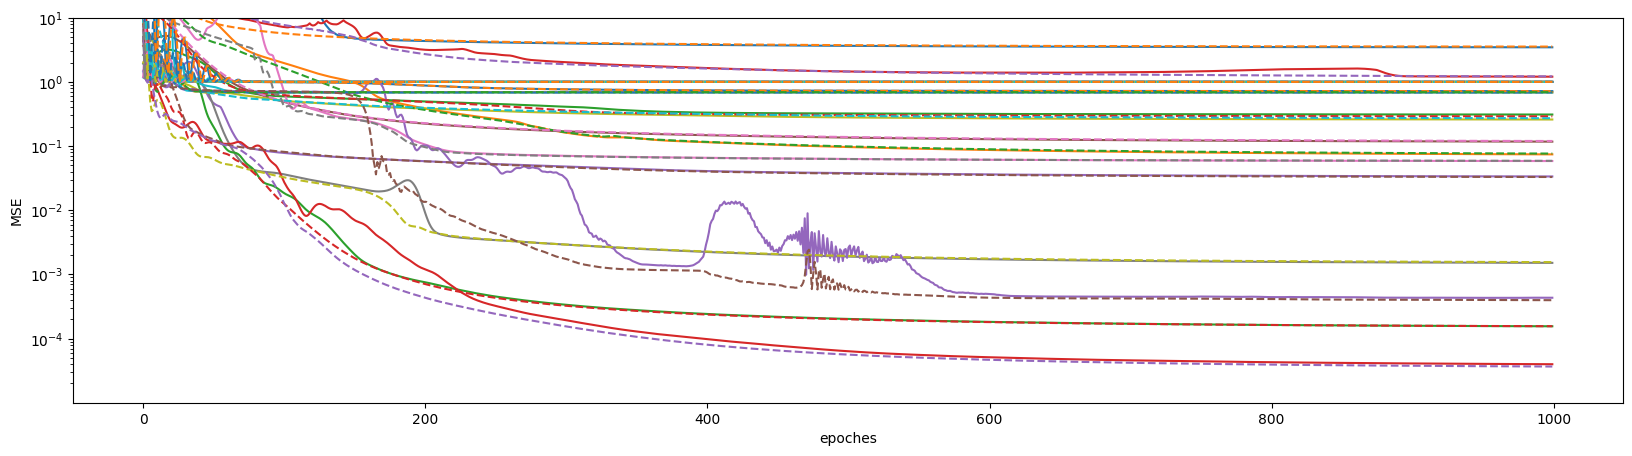

In [18]:
# ЕСЛИ УМЕНЬШАТЬ LR
plt.figure(figsize=(20, 5))
plt.plot(L2.T) # [:,100:]
plt.plot(L1.T, '--') # [:,100:]
plt.yscale('log')
plt.xlabel('epoches')
plt.ylabel('MSE')
plt.ylim([0, 10])

Text(0, 0.5, 'MSE')

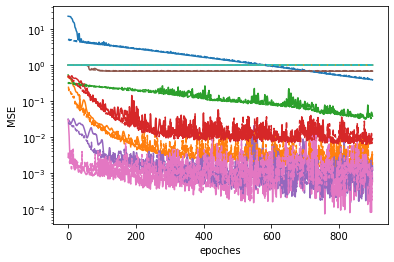

In [ ]:
# ЕСЛИ НЕ УМЕНЬШАТЬ LR
plt.plot(L2[:,100:].T)
plt.plot(L1[:,100:].T, '--')
plt.yscale('log')
plt.xlabel('epoches')
plt.ylabel('MSE')

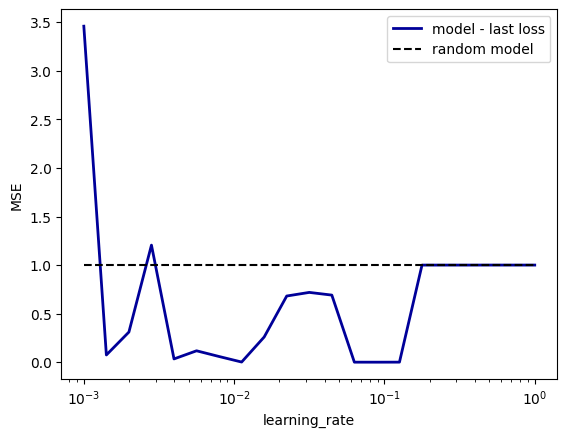

In [19]:
plt.plot(LRs, L2[:,-1], lw=2, c='#000099', label='model - last loss')
#plt.plot(LRs, np.min(L2, axis=1), lw=2, c='#FFAAAA', label='model - min loss')
plt.plot(LRs, LRs*0 + 1, '--k', label='random model')
plt.ylabel('MSE')
plt.xlabel('learning_rate')
plt.xscale('log')
# plt.ylim([0.001, 1.001])
plt.legend()

array([4.94600308e+00, 1.37276315e-01, 2.96506126e-01, 3.52098495e-01,
       1.71928394e-02, 9.96759441e-01, 1.17302259e-03, 1.00002450e+00,
       1.00000000e+00, 1.00000000e+00])

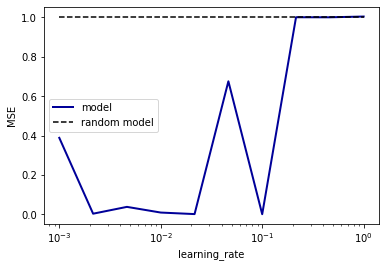

In [ ]:
plt.plot(LRs, L2[:,-1], lw=2, c='#000099', label='model')
plt.plot(LRs, LRs*0 + 1, '--k', label='random model')
plt.ylabel('MSE')
plt.xlabel('learning_rate')
plt.xscale('log')
plt.legend()

array([0.001     , 0.00215443, 0.00464159, 0.01      , 0.02154435,
       0.04641589, 0.1       , 0.21544347, 0.46415888, 1.        ])

# Эксперименты с шириной

In [20]:
m = 10000 # число объектов в выборке
#depth = 3 # увеличение признакового пространства в сети
nlayers = 5 # число слоёв в сети
learning_rate = 0.001 # 1e-3 - не обучится!
use_scheduler = True
n_epoches = 1000

Ws = np.arange(1, 11) # [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0]
n_exp = len(Ws)
L1 = np.zeros((n_exp, n_epoches))
L2 = np.zeros((n_exp, n_epoches))
for t, width in enumerate(Ws):
  set_seed(t)
  model = model_L_DN_F(width, nlayers) # ТУТ МЕНЯЕТСЯ!!!
  model.to(device)
  # MSE
  criterion = nn.MSELoss()
  # оптимизатор
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  # программатор
  scheduler = StepLR(optimizer, step_size=10, gamma=0.95)
  L1[t,:], L2[t,:] = train_model(model, optimizer, scheduler, n_epoches = n_epoches, m = m, device=device, use_scheduler=use_scheduler)
  print("[EXP]: %i, [LR]: %.6f, [LOSS1]: %.6f, [LOSS2]: %.6f" % (t, learning_rate, L1[t,-1], L2[t,-1]))
  display.clear_output(wait=True)

[EXP]: 9, [LR]: 0.001000, [LOSS1]: 0.000979, [LOSS2]: 0.000948


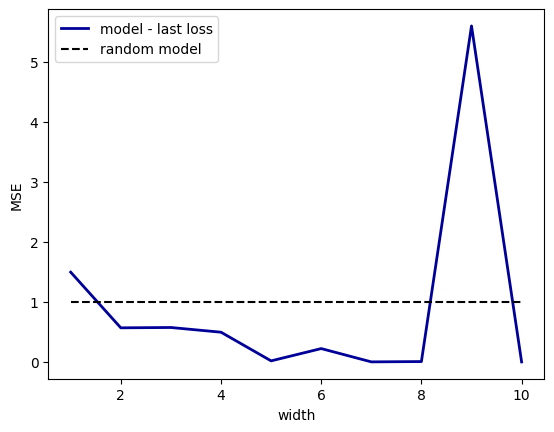

In [22]:
plt.plot(Ws, L2[:,-1], lw=2, c='#000099', label='model - last loss')
# plt.plot(Ws, np.min(L2, axis=1), lw=2, c='#FFAAAA', label='model - min loss')
plt.plot(Ws, L2[:,-1]*0 + 1, '--k', label='random model')
plt.ylabel('MSE')
plt.xlabel('width')
# plt.xscale('log')
# plt.ylim([0.001, 1.001])
plt.legend()

In [27]:
plt.figure(figsize=(20, 5))
plt.plot(L2.T) # [:,100:]
plt.plot(L1.T, '--') # [:,100:]
plt.yscale('log')
plt.xlabel('epoches')
plt.ylabel('MSE')
plt.ylim([0, 10])

# Эксперименты с глубиной

In [24]:
m = 10000 # число объектов в выборке
width = 5 # увеличение признакового пространства в сети
nlayers = 5 # число слоёв в сети
learning_rate = 0.01 # 1e-3 - не обучится!
use_scheduler = True
n_epoches = 1000

Ds = np.arange(2, 15) # [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0]
n_exp = len(Ds)
L1 = np.zeros((n_exp, n_epoches))
L2 = np.zeros((n_exp, n_epoches))
for t, nlayers in enumerate(Ds):
  set_seed(t)
  model = model_L_DN_F(width, nlayers) # ТУТ МЕНЯЕТСЯ!!!
  model.to(device)
  # MSE
  criterion = nn.MSELoss()
  # оптимизатор
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  # программатор
  scheduler = StepLR(optimizer, step_size=10, gamma=0.95)
  L1[t,:], L2[t,:] = train_model(model, optimizer, scheduler, n_epoches = n_epoches, m = m, device=device, use_scheduler=use_scheduler)
  print("[EXP]: %i, [LR]: %.6f, [LOSS1]: %.6f, [LOSS2]: %.6f" % (t, learning_rate, L1[t,-1], L2[t,-1]))
  display.clear_output(wait=True)

[EXP]: 12, [LR]: 0.010000, [LOSS1]: 0.696455, [LOSS2]: 0.699238


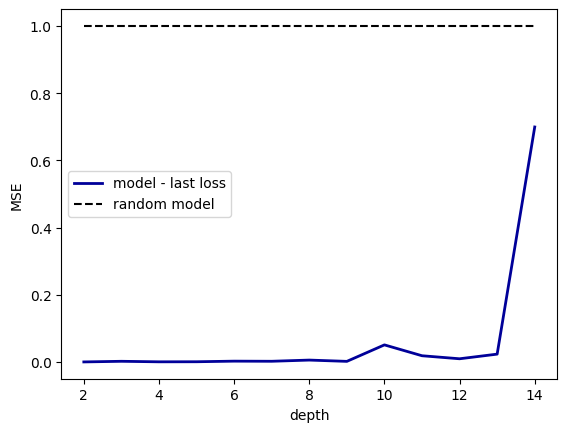

In [25]:
plt.plot(Ds, L2[:,-1], lw=2, c='#000099', label='model - last loss')
# plt.plot(Ds, np.min(L2, axis=1), lw=2, c='#FFAAAA', label='model - min loss')
plt.plot(Ds, Ds*0 + 1, '--k', label='random model')
plt.ylabel('MSE')
plt.xlabel('depth')
# plt.xscale('log')
# plt.ylim([0.001, 1.001])
plt.legend()

<ipython-input-28-3c1b7d7d1908>:7: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim([0, 10])


(5.632949531879173e-06, 10)

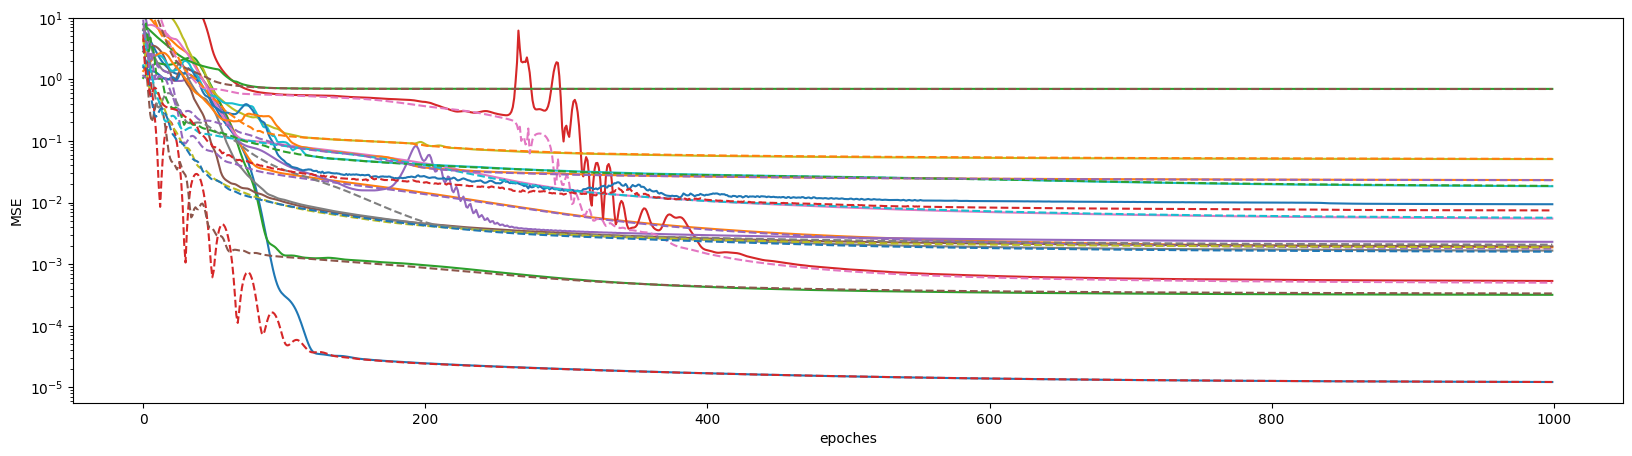

In [28]:
plt.figure(figsize=(20, 5))
plt.plot(L2.T) # [:,100:]
plt.plot(L1.T, '--') # [:,100:]
plt.yscale('log')
plt.xlabel('epoches')
plt.ylabel('MSE')
plt.ylim([0, 10])

In [69]:
m = 10000 # число объектов в выборке
nlayers = 8 # число слоёв в сети
width = 5
learning_rate = 0.01 # 1e-3 - не обучится!
use_scheduler = True
n_epoches = 1000


set_seed(10)
model = model_L_DN_F(width, nlayers) # ТУТ МЕНЯЕТСЯ!!!
model.to(device)
# MSE
criterion = nn.MSELoss()
# оптимизатор
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# программатор
scheduler = StepLR(optimizer, step_size=10, gamma=0.95)


n_epoches = 1000

losses1 = np.zeros(n_epoches)
losses2 = np.zeros(n_epoches)

set_seed(10)
# контроль
X_test, y_test = makeXtrain(m=m, device=device)


X_train, y_train = makeXtrain(m=m, device=device) # ПЕРЕНЁС СЮДА - ВЕРНУТЬ!!!!!!

for t in range(n_epoches):
    # обучение
    # небольшой датасет - сразу по всему!
    # X_train, y_train = makeXtrain(m=m, device=device) # КАЖДЫЙ РАЗ - СЛУЧАЙНЫЙ

    model.train()
    optimizer.zero_grad(set_to_none=True) # обнулить градиент ###

    a_train = model(X_train)
    loss = criterion(a_train, y_train)

    loss.backward()  # обратный проход
    optimizer.step() # поправка весов

    if use_scheduler:
      scheduler.step() # поправка LR


    with torch.no_grad():
        model.eval() ####
        a_test = model(X_test)
        test_loss = criterion(a_test, y_test)

        if t==80:
          # сохранить некоторые чекпоинты
          model1 = copy.deepcopy(model)
        elif t==900:
          model2 = copy.deepcopy(model)

        #w_norm = []
        #g_norm = []
        #for name, param in model.named_parameters():
        #    if param.requires_grad:
        #        w_norm.append(param.data.norm().item())
        #        g_norm.append(param.grad.data.norm().item())

    losses1[t] = loss.item() / (criterion(y_train, y_train*0 + y_train.mean()).item()) # НОРМИРОВКА
    losses2[t] = test_loss.item() / (criterion(y_test, y_test*0 + y_test.mean()).item()) # НОРМИРОВКА
    print("[EPOCH]: %i, [LOSS]: %.6f, [LOSS2]: %.6f" % (t, losses1[t], losses2[t]))

    display.clear_output(wait=True)


[EPOCH]: 999, [LOSS]: 0.014538, [LOSS2]: 0.014217


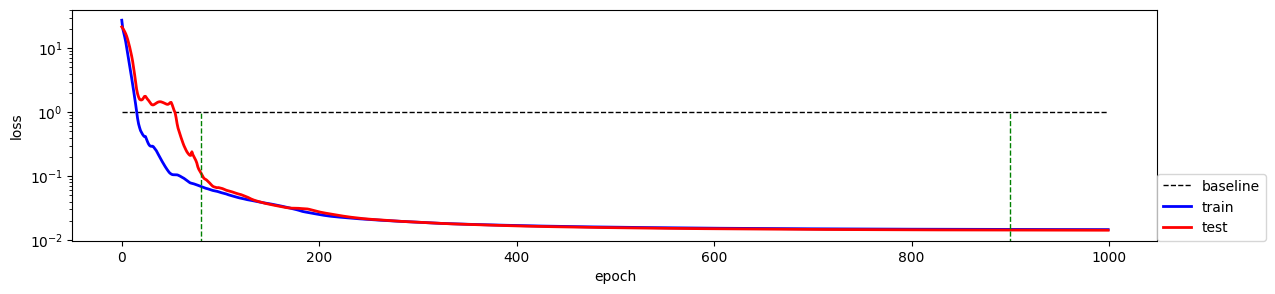

In [70]:
# ИЗ-ЗА НОРМИРОВКИ
baseline = 1; #criterion(y_test, y_test*0 + y_test.mean()).item()


plt.figure(figsize=(14, 3))
plt.plot(losses1*0 + baseline, '--', c='black', label='baseline', lw=1)
plt.plot(losses1, c='blue', label='train', lw=2)
plt.plot(losses2, c='red', label='test', lw=2)

plt.plot([80, 80], [0, 1], '--', c='green', lw=1)
plt.plot([900, 900], [0, 1], '--', c='green', lw=1)
#plt.ylim([0.5, 1.2])
#plt.xlim([0, 100])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc=(1,0))
plt.yscale('log')

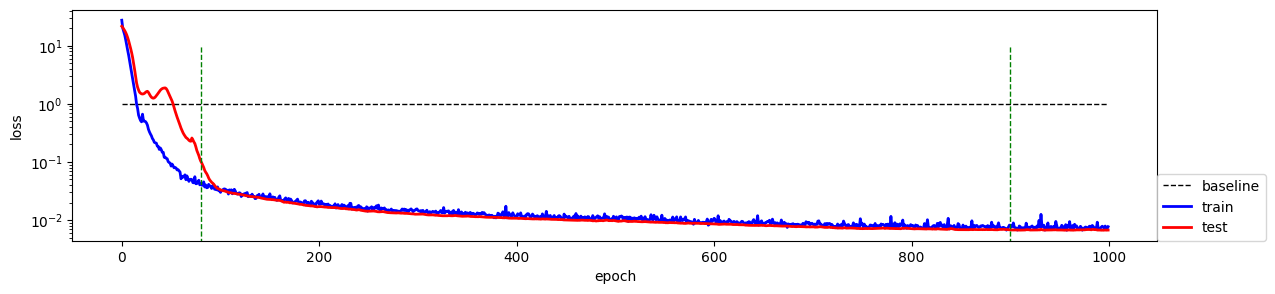

In [51]:
# ИЗ-ЗА НОРМИРОВКИ
baseline = 1; #criterion(y_test, y_test*0 + y_test.mean()).item()


plt.figure(figsize=(14, 3))
plt.plot(losses1*0 + baseline, '--', c='black', label='baseline', lw=1)
plt.plot(losses1, c='blue', label='train', lw=2)
plt.plot(losses2, c='red', label='test', lw=2)

plt.plot([80, 80], [0, 10], '--', c='green', lw=1)
plt.plot([900, 900], [0, 10], '--', c='green', lw=1)
# plt.ylim([0.00, 0.5])
# plt.xlim([0, 100])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc=(1,0))
plt.yscale('log')

In [74]:
model1.train()
a = model1(X_test)
criterion(a, y_test)

tensor(0.0015, device='cuda:0', grad_fn=<MseLossBackward0>)

In [72]:
model1.eval()
a = model1(X_test)
criterion(a, y_test)

tensor(0.0022, device='cuda:0', grad_fn=<MseLossBackward0>)

In [73]:
criterion(model1(X_train), y_train)

tensor(0.0022, device='cuda:0', grad_fn=<MseLossBackward0>)

In [75]:
model2.train()
a = model2(X_test)
criterion(a, y_test)

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)

In [76]:
model2.eval()
a = model2(X_test)
criterion(a, y_test)

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)

In [ ]:
print (model2.L0.weight, model2.L0.bias)
print (model2.L1.weight, model2.L1.bias)
print (model2.L2.weight, model2.L2.bias)
print (model2.L3.weight, model2.L3.bias)
print (model2.L4.weight, model2.L4.bias)

Parameter containing:
tensor([[-0.0838],
        [-0.0343],
        [-0.3750]], device='cuda:0', requires_grad=True) Parameter containing:
tensor([ 0.2300, -0.5721, -0.1763], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[ 0.2238,  0.5419,  0.1360],
        [-0.1959,  0.0554, -0.0647],
        [ 0.2357,  0.0661,  0.2262]], device='cuda:0', requires_grad=True) Parameter containing:
tensor([ 0.5599, -0.2397, -0.0204], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[ 0.1328, -0.0038, -0.0553],
        [-0.5109, -0.4980, -0.5195],
        [-0.5649, -0.5377, -0.4374]], device='cuda:0', requires_grad=True) Parameter containing:
tensor([-0.5207, -0.5416,  0.2531], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[ 0.3541,  0.3901,  0.3110],
        [ 0.1956,  0.2543, -0.3193],
        [ 0.5198, -0.0398,  0.4981]], device='cuda:0', requires_grad=True) Parameter containing:
tensor([0.1068, 0.3771, 0.5558], device='cuda:0', requires_grad

In [38]:
model

Sequential(
  (L0): Linear(in_features=1, out_features=5, bias=False)
  (BN0): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (RELU0): ReLU()
  (L1): Linear(in_features=5, out_features=5, bias=False)
  (BN1): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (RELU1): ReLU()
  (L2): Linear(in_features=5, out_features=5, bias=False)
  (BN2): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (RELU2): ReLU()
  (L3): Linear(in_features=5, out_features=5, bias=False)
  (BN3): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (RELU3): ReLU()
  (L4): Linear(in_features=5, out_features=5, bias=False)
  (BN4): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (RELU4): ReLU()
  (L5): Linear(in_features=5, out_features=5, bias=False)
  (BN5): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (RELU5): ReLU()
  (L

In [ ]:
print (model2.BN0.running_mean)
print (model2.BN1.running_mean)
print (model2.BN2.running_mean)
print (model2.BN3.running_mean)

tensor([ 0.2819, -0.5991, -0.1425], device='cuda:0')
tensor([ 0.3575, -0.0388,  0.2018], device='cuda:0')
tensor([-0.0918, -0.0171, -0.6441], device='cuda:0')
tensor([-0.4377, -0.2615,  0.3360], device='cuda:0')


In [ ]:
print (model2.BN0.weight)
print (model2.BN1.weight)
print (model2.BN2.weight)
print (model2.BN3.weight)

Parameter containing:
tensor([0.8958, 1.0448, 0.9531], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([0.8940, 1.1702, 0.9403], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([0.6982, 0.9483, 1.1477], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([0.8701, 0.8513, 0.9211], device='cuda:0', requires_grad=True)


In [ ]:
print (model2.BN0.bias)
print (model2.BN1.bias)
print (model2.BN2.bias)
print (model2.BN3.bias)

Parameter containing:
tensor([ 0.3160, -0.0627,  0.2927], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([-0.1081,  0.2205, -0.0577], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([-0.2252, -0.2685,  0.1750], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([-0.1268, -0.1483,  0.0209], device='cuda:0', requires_grad=True)


In [ ]:
print (model2.BN0.running_var)
print (model2.BN1.running_var)
print (model2.BN2.running_var)
print (model2.BN3.running_var)

tensor([1.7370e-07, 2.8387e-04, 7.2207e-03], device='cuda:0')
tensor([0.1600, 0.0002, 0.0372], device='cuda:0')
tensor([5.6423e-02, 3.3600e-04, 5.0877e-01], device='cuda:0')
tensor([0.0953, 0.0307, 0.0717], device='cuda:0')


In [ ]:
print (model2.BN0.num_features)
print (model2.BN0.eps)
print (model2.BN0.momentum)
print (model2.BN0.affine)
print (model2.BN0.track_running_stats)

3
1e-05
0.1
True
True


In [ ]:
model2

Sequential(
  (L0): Linear(in_features=1, out_features=3, bias=True)
  (BN0): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (RELU0): ReLU()
  (L1): Linear(in_features=3, out_features=3, bias=False)
  (BN1): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (RELU1): ReLU()
  (L2): Linear(in_features=3, out_features=3, bias=False)
  (BN2): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (RELU2): ReLU()
  (L3): Linear(in_features=3, out_features=3, bias=False)
  (BN3): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (RELU3): ReLU()
  (L4): Linear(in_features=3, out_features=1, bias=True)
)

# Loss

In [40]:
# Поверхности

def init_directions_frommodels(model, model1, model2):
    # из чекпоинтов
    noises = []

    n_params = 0
    for t, t1, t2 in zip(model.parameters(), model1.parameters(), model2.parameters()):
        delta = t.detach() - t1.detach()
        nu = t.detach() - t2.detach()

        t_norm = torch.norm(t)
        delta_norm = torch.norm(delta)
        nu_norm = torch.norm(nu)

        delta /= delta_norm
        delta *= t_norm

        nu /= nu_norm
        nu *= t_norm

        noises.append((delta, nu))

        n_params += np.prod(t.size())

    print(f'A total of {n_params:,} parameters.')

    return noises


def init_network(model, model_tmp, all_noises, alpha, beta):
    with torch.no_grad():
        for param, param_tmp, noises in zip(model.parameters(), model_tmp.parameters(), all_noises):
            delta, nu = noises
            # the scaled noises added to the current filter
            new_value = param + alpha * delta + beta * nu
            param_tmp.copy_(new_value)
    return model_tmp

In [41]:
# Creating the initial noise directions
# noises = init_directions(model)
noises = init_directions_frommodels(model, model1, model2)

# модель для экспериментов
model_tmp = copy.deepcopy(model)

# Our loss function (for categorical problems)
crit = nn.MSELoss()

RESOLUTION = 61
scale = 0.3

# The mesh-grid
A, B = np.meshgrid(scale*np.linspace(-1.0, 1.0, RESOLUTION),
                   scale*np.linspace(-1.0, 1.0, RESOLUTION), indexing='ij')

loss_surface = np.empty_like(A)

for i in range(RESOLUTION):
    for j in range(RESOLUTION):
        alpha = A[i, j]
        beta = B[i, j]
        # Initilazing the network to the current directions (alpha, beta)
        model_tmp = init_network(model, model_tmp, noises, alpha, beta) #.to('cuda')

        model_tmp.eval()

        with torch.no_grad():
          preds = model_tmp(X_test)
          loss = crit(preds, y_test)

        loss_surface[i, j] = loss.item()

        # print (alpha, beta, loss.item())
        # Freeing up GPU memory
del model_tmp
#torch.cuda.empty_cache()


A total of 231 parameters.


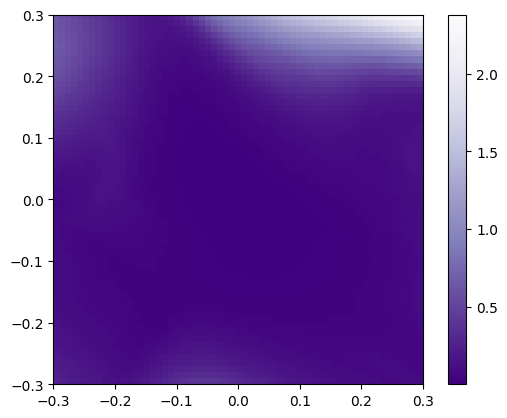

In [42]:
plt.imshow(np.log1p(loss_surface), extent=[-scale, scale, -scale, scale], origin='lower',
           cmap='Purples_r', alpha=1.0)
plt.colorbar()

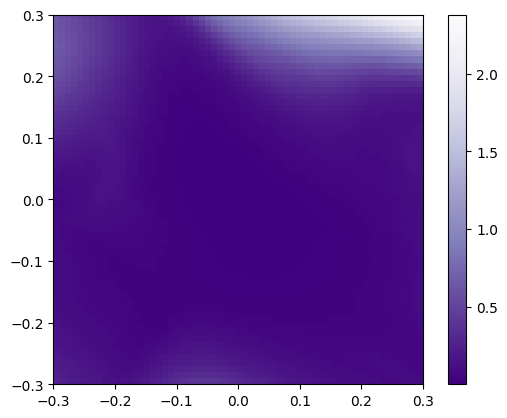

In [43]:
plt.imshow(np.log1p(loss_surface), extent=[-scale, scale, -scale, scale], origin='lower',
           cmap='Purples_r', alpha=1.0)
plt.colorbar()

In [ ]:
model.to('cpu')
X1 = (torch.arange(1001)/1000).reshape((1001, 1)) - 0.5
y1 = X1.abs()

In [ ]:
model.eval()
a = model(X1)

In [ ]:
a

tensor([[0.3114],
        [0.3112],
        [0.3109],
        ...,
        [0.2400],
        [0.2400],
        [0.2400]], grad_fn=<AddmmBackward0>)

In [ ]:
a.shape, y1.shape

(torch.Size([1001, 1]), torch.Size([1001, 1]))

In [ ]:
x0 = X1.clone()
for f in model:
  x0 = f(x0)
  print (x0.shape)

torch.Size([1001, 3])
torch.Size([1001, 3])
torch.Size([1001, 3])
torch.Size([1001, 3])
torch.Size([1001, 3])
torch.Size([1001, 3])
torch.Size([1001, 3])
torch.Size([1001, 3])
torch.Size([1001, 3])
torch.Size([1001, 3])
torch.Size([1001, 3])
torch.Size([1001, 3])
torch.Size([1001, 1])


In [ ]:
a_train

tensor([[0.2389],
        [0.2363],
        [0.2385],
        ...,
        [0.2370],
        [0.2761],
        [0.2418]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [ ]:
a_test

tensor([[0.2358],
        [0.2360],
        [0.2464],
        ...,
        [0.3039],
        [0.2393],
        [0.3111]], device='cuda:0')

Text(0, 0.5, 'y_test')

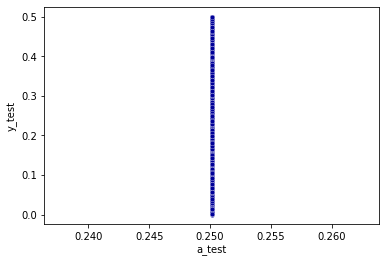

In [ ]:
plt.scatter(a_test.detach().cpu(), y_test.detach().cpu(), 20, c='#000099', edgecolor='w', lw=0.3)
#plt.xlim([0, 1])
#plt.ylim([0, 1])
plt.xlabel('a_test')
plt.ylabel('y_test')

Text(0, 0.5, 'y_train')

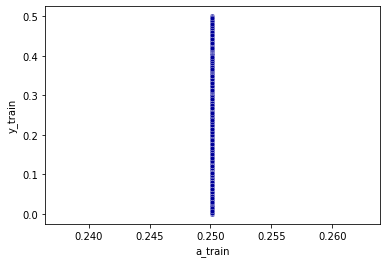

In [ ]:
plt.scatter(a_train.detach().cpu(), y_train.detach().cpu(), 20, c='#000099', edgecolor='w', lw=0.3)
#plt.xlim([0, 1])
#plt.ylim([0, 1])
plt.xlabel('a_train')
plt.ylabel('y_train')

Text(0, 0.5, 'y_train')

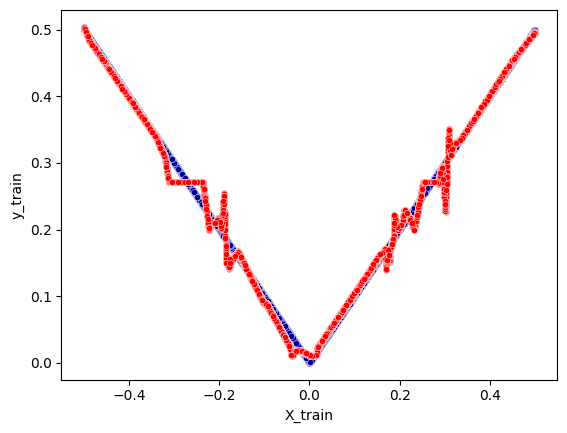

In [39]:
plt.scatter(X_train.detach().cpu(), y_train.detach().cpu(), 20, c='#000099', edgecolor='w', lw=0.3)
plt.scatter(X_train.detach().cpu(), a_train.detach().cpu(), 20, c='#FF0000', edgecolor='w', lw=0.3)
#plt.xlim([0, 1])
#plt.ylim([0, 1])
plt.xlabel('X_train')
plt.ylabel('y_train')

Text(0, 0.5, 'y_test')

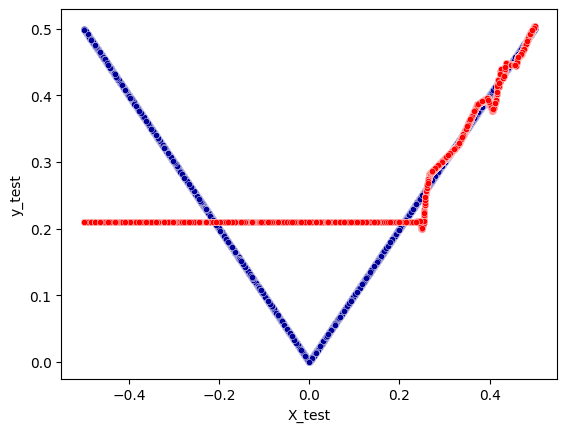

In [32]:
plt.scatter(X_test.detach().cpu(), y_test.detach().cpu(), 20, c='#000099', edgecolor='w', lw=0.3)
plt.scatter(X_test.detach().cpu(), a_test.detach().cpu(), 20, c='#FF0000', edgecolor='w', lw=0.3)
#plt.xlim([0, 1])
#plt.ylim([0, 1])
plt.xlabel('X_test')
plt.ylabel('y_test')

In [ ]:
a_train.shape, y_train.shape

(torch.Size([10000, 1]), torch.Size([10000, 1]))

Text(0, 0.5, 'y_train')

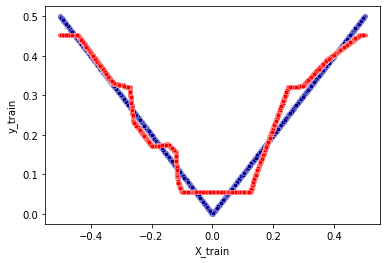

In [ ]:
plt.scatter(X_train.detach().cpu(), y_train.detach().cpu(), 20, c='#000099', edgecolor='w', lw=0.3)
plt.scatter(X_train.detach().cpu(), a_train.detach().cpu(), 20, c='#FF0000', edgecolor='w', lw=0.3)
#plt.xlim([0, 1])
#plt.ylim([0, 1])
plt.xlabel('X_train')
plt.ylabel('y_train')

Text(0, 0.5, 'y_test')

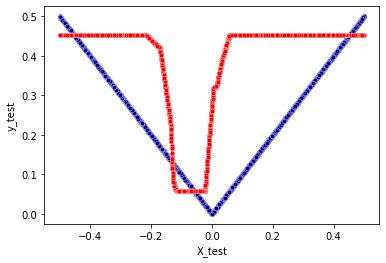

In [ ]:
plt.scatter(X_test.detach().cpu(), y_test.detach().cpu(), 20, c='#000099', edgecolor='w', lw=0.3)
plt.scatter(X_test.detach().cpu(), a_test.detach().cpu(), 20, c='#FF0000', edgecolor='w', lw=0.3)
#plt.xlim([0, 1])
#plt.ylim([0, 1])
plt.xlabel('X_test')
plt.ylabel('y_test')

Text(0, 0.5, 'y1')

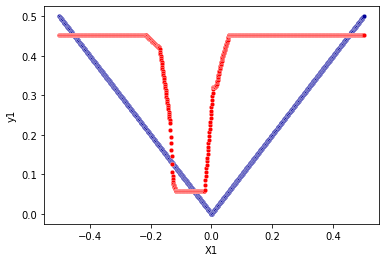

In [ ]:
plt.scatter(X1.detach().cpu(), y1.detach().cpu(), 20, c='#000099', edgecolor='w', lw=0.3)
plt.scatter(X1.detach().cpu(), a.detach().cpu(), 20, c='#FF0000', edgecolor='w', lw=0.3)
#plt.xlim([0, 1])
#plt.ylim([0, 1])
plt.xlabel('X1')
plt.ylabel('y1')

In [ ]:
X_train.mean(), X_test.mean(), X_train.std(), X_test.std()

(tensor(-0.0028), tensor(0.0011), tensor(0.2898), tensor(0.2884))

In [ ]:
model.train()
b = model(X1)

Text(0, 0.5, 'y1')

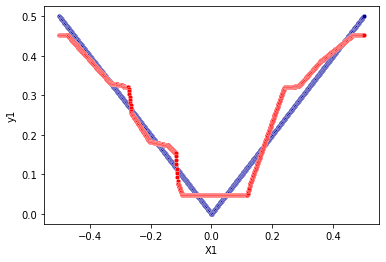

In [ ]:
plt.scatter(X1.detach().cpu(), y1.detach().cpu(), 20, c='#000099', edgecolor='w', lw=0.3)
plt.scatter(X1.detach().cpu(), b.detach().cpu(), 20, c='#FF0000', edgecolor='w', lw=0.3)
#plt.xlim([0, 1])
#plt.ylim([0, 1])
plt.xlabel('X1')
plt.ylabel('y1')

In [ ]:
model

Sequential(
  (L0): Linear(in_features=1, out_features=3, bias=True)
  (BN0): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (RELU0): ReLU()
  (L1): Linear(in_features=3, out_features=3, bias=False)
  (BN1): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (RELU1): ReLU()
  (L2): Linear(in_features=3, out_features=3, bias=False)
  (BN2): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (RELU2): ReLU()
  (L3): Linear(in_features=3, out_features=3, bias=False)
  (BN3): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (RELU3): ReLU()
  (L4): Linear(in_features=3, out_features=1, bias=True)
)

In [ ]:
model

Sequential(
  (L0): Linear(in_features=1, out_features=3, bias=True)
  (RELU0): ReLU()
  (L1): Linear(in_features=3, out_features=3, bias=True)
  (RELU1): ReLU()
  (L2): Linear(in_features=3, out_features=3, bias=True)
  (RELU2): ReLU()
  (L3): Linear(in_features=3, out_features=3, bias=True)
  (RELU3): ReLU()
  (L4): Linear(in_features=3, out_features=1, bias=True)
)

In [ ]:
y_train.shape

torch.Size([10000, 1])

In [ ]:
y_train.float()

tensor([[0.3561],
        [0.0189],
        [0.3050],
        ...,
        [0.1204],
        [0.3303],
        [0.1658]], device='cuda:0')

In [ ]:
! nvidia-smi

Tue Nov 15 07:58:57 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [44]:
! nvidia-smi

Thu Jan 11 15:18:40 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P0              27W /  70W |    165MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--